In [1]:
# Load the dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

data = pd.read_csv('hour.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [2]:
import h2o
from h2o.automl import H2OAutoML
import numpy as np
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# Initialize H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 hours 13 mins
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.2
H2O_cluster_version_age:,26 days
H2O_cluster_name:,H2O_from_python_heriG_iamb79
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,5.862 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [4]:
# Select relevant columns
features = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
target = 'cnt'

X = data[features]
y = data[target]

In [6]:
# One-hot encode categorical variables
cat_features = ['season', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit']
encoder = OneHotEncoder(drop='first', sparse=False)
X_encoded = encoder.fit_transform(X[cat_features])

In [7]:
# Standardize numerical features
num_features = ['temp', 'atemp', 'hum', 'windspeed']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X[num_features])

# Combine encoded categorical and scaled numerical features
X_processed = pd.concat([pd.DataFrame(X_encoded, columns=encoder.get_feature_names(cat_features)), pd.DataFrame(X_scaled, columns=num_features)], axis=1)

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [9]:
# Convert data to H2O frame
train_data = h2o.H2OFrame(pd.concat([X_train, y_train], axis=1))
test_data = h2o.H2OFrame(pd.concat([X_test, y_test], axis=1))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [10]:
# Define AutoML model
automl = H2OAutoML(max_runtime_secs=600, seed=42)
automl.train(x=X_train.columns.tolist(), y=target, training_frame=train_data)

# Get best model
best_model = automl.leader

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


In [11]:
import xgboost as xgb

# XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

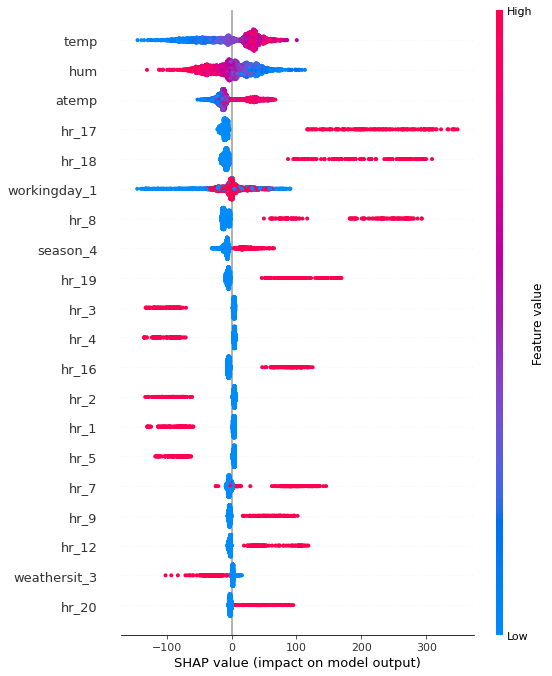

In [12]:
# SHAP explanation for XGBoost model
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# SHAP plots for XGBoost model
shap.summary_plot(shap_values, X_test)

# Feature importance for XGBoost model
feature_importance = xgb_model.feature_importances_

# XGBoost model evaluation
mse = ((xgb_model.predict(X_test) - y_test) ** 2).mean()

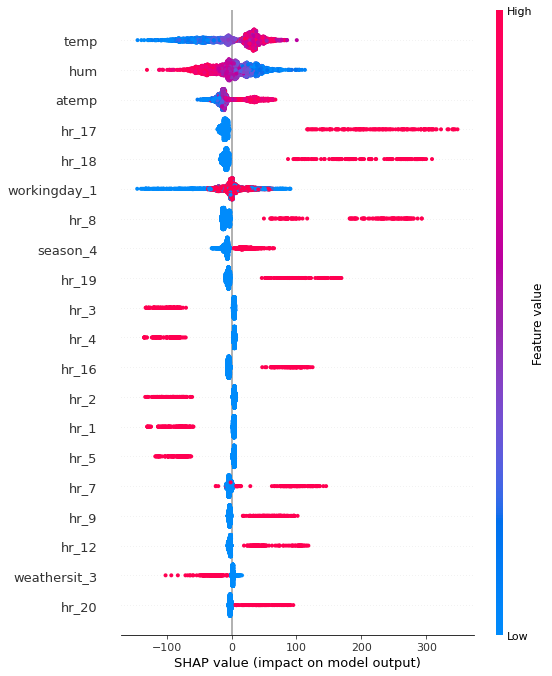

In [13]:
# SHAP plots for AutoML model
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Feature importance for AutoML model
feature_importance = best_model.varimp(use_pandas=True)

In [14]:
# Report findings based on plots, feature importance, and model evaluation
print("Feature Importance:\n", feature_importance)
print("AutoML Model MSE:", best_model.mse())
print("XGBoost Model MSE:", mse)

Feature Importance:
 None
AutoML Model MSE: 2177.3948811073697
XGBoost Model MSE: 5460.229084084392
